In [1]:
import math
import itertools
import os
from pathlib import Path
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
FIGURES_DIRECTORY = KWARGS['figure_directory']
GRID = pd.read_csv(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/misc/hyperparameter_design_grid.csv'))
SIMULATION_IDS = GRID['simulation_id'].unique()
RESULT_SUMMARY = pd.read_csv(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/buildsys_2022/data/summary/hyperparameter_design_brief.csv'))
RESULT_SUMMARY = GRID.merge(RESULT_SUMMARY, on='simulation_id', how='left')
RESULT_SUMMARY = RESULT_SUMMARY.groupby([
    'group', 'discount', 'tau', 'lr', 'alpha', 'buildings', 'experiment', 'episode', 'building_id', 'building_name',
])[[
    'reward_sum', 'reward_mean',
    'net_electricity_consumption_sum',
    'net_electricity_consumption_emission_sum',
    'net_electricity_consumption_price_sum',
    'net_electricity_consumption_without_storage_sum',
    'net_electricity_consumption_emission_without_storage_sum',
    'net_electricity_consumption_price_without_storage_sum'
]].mean().reset_index()

# Building reward trajectory

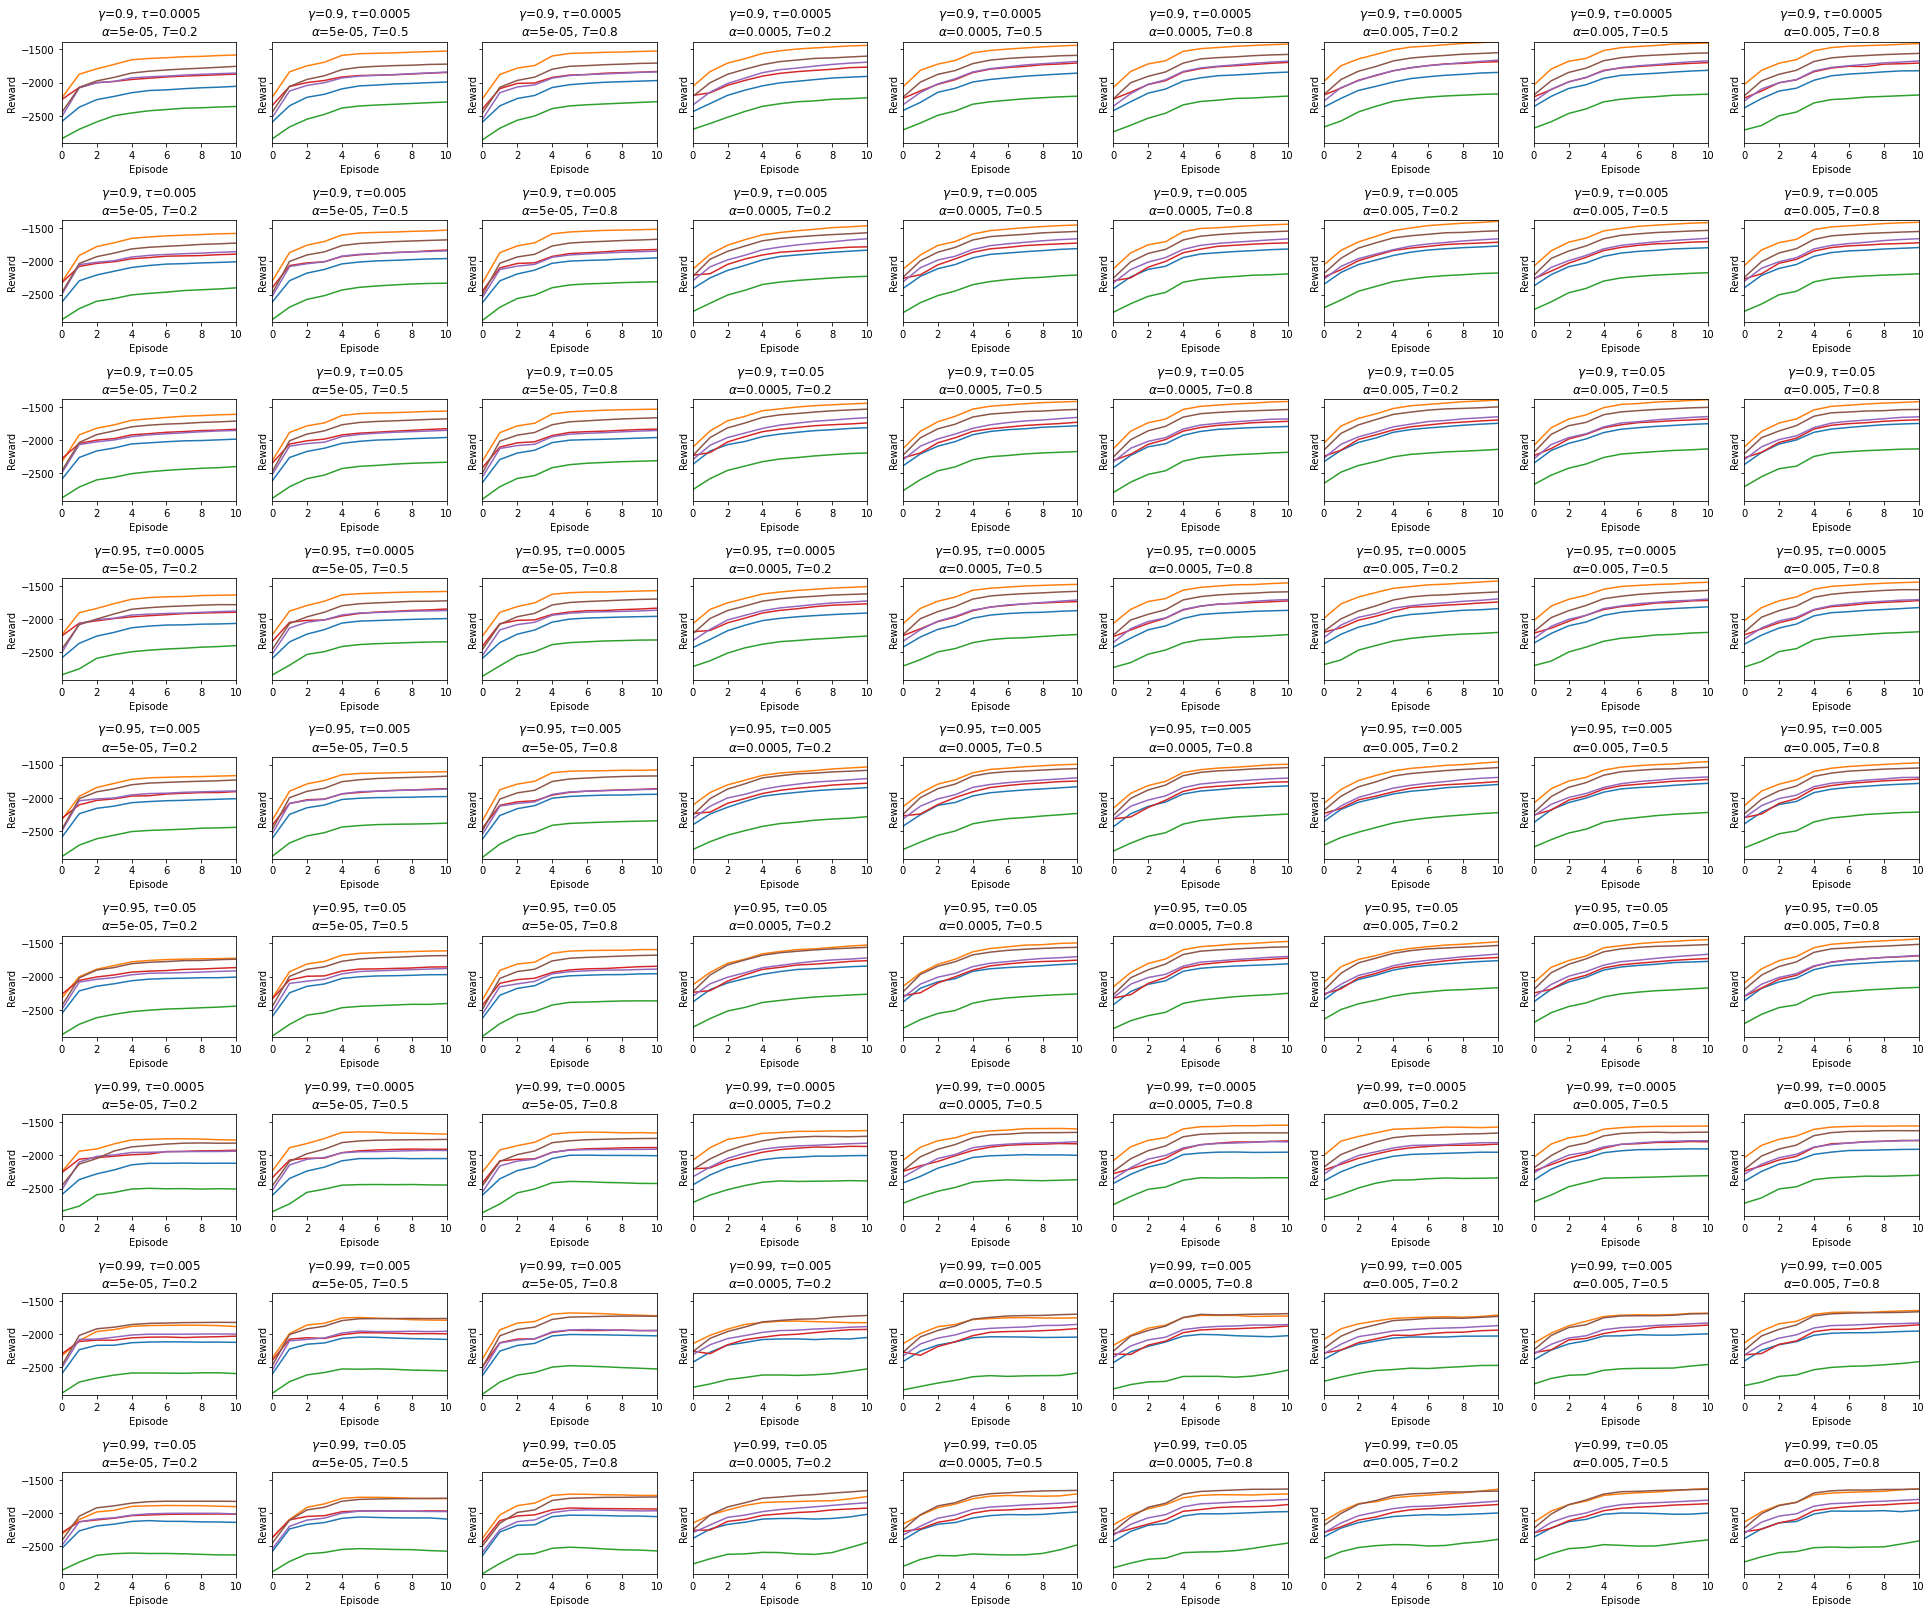

In [17]:
column_count_limit = 9
hyperparameters = RESULT_SUMMARY[['discount', 'tau', 'lr', 'alpha']].drop_duplicates()
row_count = math.ceil(len(hyperparameters)/column_count_limit)
column_count = min(column_count_limit, len(hyperparameters))
fig, _ = plt.subplots(row_count, column_count, figsize=(column_count*3, row_count*2.5), sharey=True)

for i, (ax, ((d, t, l, a), h_data)) in enumerate(zip(fig.axes, RESULT_SUMMARY.groupby(['discount', 'tau', 'lr', 'alpha']))):
    for j, (b, b_data) in enumerate(h_data.groupby('building_name')):
        x, y = b_data['episode'], b_data['reward_sum']
        ax.plot(x, y, label=b)
    
    ax.set_title(r'$\gamma$=' + str(d) + r', $\tau$=' + str(t) + '\n' + r'$\alpha$=' + str(l) + r', $T$=' + str(a))
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')

plt.tight_layout()
plt.show()

# Hyperparameter Combination Scatter

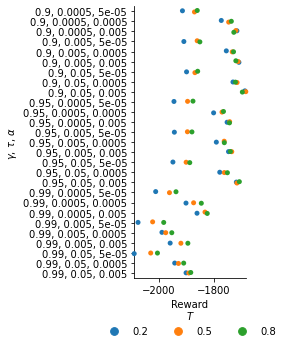

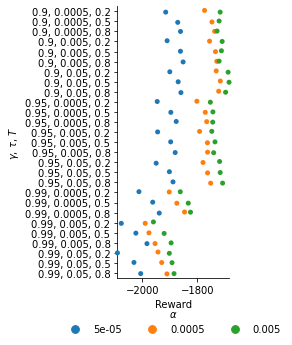

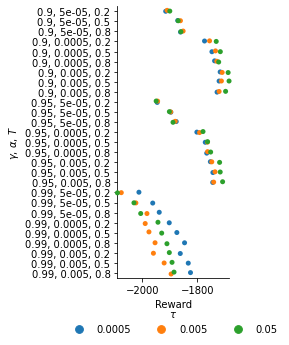

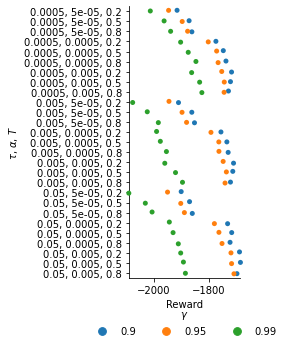

In [96]:
combinations = itertools.combinations(['discount', 'tau', 'lr', 'alpha'], 3)
combinations = [c for c in combinations]
row_count = 1
column_count = 1
plot_data = RESULT_SUMMARY[RESULT_SUMMARY['episode'] == RESULT_SUMMARY['episode'].max()].copy()
label_dict = {
    'discount': {'name': 'Discount factor', 'symbol': r'$\gamma$'},
    'tau': {'name': 'Decay rate', 'symbol': r'$\tau$'},
    'lr': {'name': 'Learning rate', 'symbol': r'$\alpha$'},
    'alpha': {'name': 'Temperature', 'symbol': r'$T$'},
}

for i, c in enumerate(combinations):
    l = [c_ for c_ in ['discount', 'tau', 'lr', 'alpha'] if c_ not in c][0]
    c_data = plot_data.groupby(list(c) + [l])[['reward_sum']].mean().reset_index()
    c_data['label'] = c_data.apply(lambda x: str(', '.join([str(x[c_]) for c_ in c])), axis=1)
    fig, ax = plt.subplots(row_count, column_count, figsize=(column_count*2.0, row_count*5.0))
    sns.stripplot(y='label', x='reward_sum', data=c_data, hue=l, ax=ax, clip_on=False)
    ax.set_ylabel(', '.join([label_dict[c_]["symbol"] for c_ in c]))
    ax.set_xlabel('Reward')
    ax.tick_params('x',which='both',rotation=0)
    
    for s in ['right','top']:
        ax.spines[s].set_visible(False)

    ax.legend(
        title=label_dict[l]['symbol'],
        bbox_to_anchor=(0.5, -0.08),
        loc='upper center',
        framealpha=0,
        ncol=3
    )

    plt.savefig(os.path.join(FIGURES_DIRECTORY,f'last_episode_hyperparameter_combination_constant_{l}_reward.pdf'),bbox_inches='tight',transparent=True)
    plt.show()

# Final Hyperparameter Selection

In [8]:
plot_data = RESULT_SUMMARY[RESULT_SUMMARY['episode'] == RESULT_SUMMARY['episode'].max()].copy()
plot_data = plot_data.pivot_table(index=['discount', 'tau', 'lr', 'alpha'], columns='building_name', values='reward_sum')
building_names = plot_data.columns
plot_data['average'] = plot_data.mean(axis=1)
plot_data = plot_data.round(1)
plot_data = plot_data.reset_index(drop=False)
plot_data = plot_data.sort_values('average', ascending=False)
display(plot_data.head(30))

for b in building_names:
    b_data = plot_data.sort_values(b, ascending=False).iloc[0]
    print(b, ':', b_data[['discount', 'tau', 'lr', 'alpha', b]].to_dict())

building_name,discount,tau,lr,alpha,Building_2,Building_3,Building_6,Building_7,Building_8,Building_9,average
25,0.90,0.0500,0.0050,0.5,-1752.4,-1392.1,-2132.3,-1680.5,-1644.9,-1506.9,-1684.9
24,0.90,0.0500,0.0050,0.2,-1746.8,-1398.9,-2139.0,-1697.4,-1648.2,-1498.9,-1688.2
26,0.90,0.0500,0.0050,0.8,-1749.0,-1421.1,-2131.9,-1694.1,-1649.6,-1538.7,-1697.4
53,0.95,0.0500,0.0050,0.8,-1763.8,-1434.6,-2163.7,-1688.8,-1682.9,-1516.0,-1708.3
15,0.90,0.0050,0.0050,0.2,-1770.0,-1398.5,-2175.7,-1712.8,-1661.4,-1540.8,-1709.9
16,0.90,0.0050,0.0050,0.5,-1795.5,-1416.8,-2171.3,-1704.0,-1653.6,-1534.4,-1712.6
22,0.90,0.0500,0.0005,0.5,-1783.6,-1417.3,-2171.8,-1730.6,-1658.3,-1537.8,-1716.6
52,0.95,0.0500,0.0050,0.5,-1772.4,-1444.1,-2171.6,-1729.5,-1665.2,-1519.0,-1717.0
6,0.90,0.0005,0.0050,0.2,-1847.7,-1384.1,-2171.5,-1686.2,-1662.3,-1550.9,-1717.1
51,0.95,0.0500,0.0050,0.2,-1761.2,-1478.1,-2168.4,-1713.3,-1661.9,-1532.1,-1719.2


Building_2 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.2, 'Building_2': -1746.8}
Building_3 : {'discount': 0.9, 'tau': 0.0005, 'lr': 0.005, 'alpha': 0.2, 'Building_3': -1384.1}
Building_6 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.8, 'Building_6': -2131.9}
Building_7 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.5, 'Building_7': -1680.5}
Building_8 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.5, 'Building_8': -1644.9}
Building_9 : {'discount': 0.9, 'tau': 0.05, 'lr': 0.005, 'alpha': 0.2, 'Building_9': -1498.9}
